In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib as mpl
from scipy import stats
from statsmodels.stats import multitest
from collections import defaultdict
from pathlib import Path

# plot settings
mpl.rcParams["figure.dpi"] = 200
mpl.rcParams["legend.fontsize"] = 12.5
mpl.rcParams["font.size"] = 14
mpl.rcParams["axes.grid"] = True
mpl.rcParams["grid.alpha"] = 0.3
mpl.rcParams["axes.axisbelow"] = True

TEX_PLOTS = True

if TEX_PLOTS:
    plt.rc("text", usetex=True)
    plt.rc("text.latex", preamble=r"""
     \usepackage{times}
     \usepackage{mathptmx}""")
else:
    plt.rc("text", usetex=False)
    
plt.rc("font", family="serif")

WSPACE = 0.365
FOUR_COL_FIGSIZE = (23, 3)
TWO_COL_FIGSIZE = (FOUR_COL_FIGSIZE[0]/2, FOUR_COL_FIGSIZE[1])

# Experiment 1

The aim of this experiment is to show the global behaviour of the system, in terms of stability and task allocation. Firstly we will have a broad look and then a focused look, to understand what causes extinction (spoiler: unlucky start due to the environment.)

In [2]:
#Run for experiment 1
#The same parameters as OFAT (Fixed_parameters above)
# python ./run_model.py data/time_steps_data_experiment_1.npz --repetitions=200 --n-cores=12 --time-steps=1000

In [3]:
data_ex1 = np.load("data/time_steps_data_experiment_1.npz", allow_pickle=True)
dfs_ex1 = [pd.DataFrame.from_dict(d) for d in data_ex1["results"]]
dfs_ex1_unchanged = dfs_ex1.copy()
t = len(dfs_ex1[0])

In [4]:
n_extinctions = 0
for i, df in enumerate(dfs_ex1):
    #rename collumns
    df = df.rename(columns={"Ant Biomass": "Number of Ants", "Fraction forager ants": "Fraction Forager Ants",
                        "Dormant caretakers fraction":"Fraction Dormant Caretakers"})
    dfs_ex1[i] = df
    if df["Number of Ants"].iloc[-1] < 5:
        n_extinctions += 1
print(f"{n_extinctions} out of {len(dfs_ex1)} runs went extinct")

80 out of 200 runs went extinct


In [5]:

n_extinctions = 0
for i, df in enumerate(dfs_ex1_unchanged):
    #rename collumns
    df = df.rename(columns={"Ant Biomass": "Number of Ants", "Fraction forager ants": "Fraction Forager Ants",
                        "Dormant caretakers fraction":"Fraction Dormant Caretakers"})
    dfs_ex1_unchanged[i] = df
    if df["Number of Ants"].iloc[-1] < 5:
        n_extinctions += 1
print(f"{n_extinctions} out of {len(dfs_ex1)} runs went extinct")

80 out of 200 runs went extinct


In [6]:
#Remove trailing zeros, as fraction set to 0 when extinct, hence wrong
for df in dfs_ex1:
    df["Fraction Forager Ants"] = np.trim_zeros(df["Fraction Forager Ants"], "b")
    df["Fraction Dormant Caretakers"] = np.trim_zeros(df["Fraction Dormant Caretakers"], "b")

In [7]:
extinct_ex1 = []
survive_ex1 = []
for df in dfs_ex1:
    if df["Number of Ants"].iloc[-1] < 5:
        extinct_ex1.append(df)
    else: 
        survive_ex1.append(df)

In [16]:
def plot_mean_std(list_dfs, experiment_name, measures, colors, wspace=WSPACE, y_range_max=None, x_lim=None):
    fig = plt.figure(figsize=FOUR_COL_FIGSIZE)
    
    concat_df = pd.concat(list_dfs)
    grouped_df = concat_df.groupby(level=0)
    means_df = grouped_df.mean()
    std_df = grouped_df.std()
    
    output_dir = f"figures/experiments/"
    Path(output_dir).mkdir(parents=True, exist_ok=True)
    
    for i, (measure, color) in enumerate(zip(cols, colors)):
        ax = fig.add_subplot(1, len(cols), i+1)
        ax.plot(range(t), means_df[measure], label=measure, color=color)
        mean_min_std = means_df[measure] - std_df[measure]
        #mean_min_std[mean_min_std < 0] = 0
    
        ax.fill_between(range(t),
                        mean_min_std, means_df[measure] + std_df[measure],
                        alpha=0.4, color=color)

        ax.set_xlabel("$t$")
        ax.set_ylabel(f"{measure}")
        if y_range_max:
            ax.set_ylim(-0.05*y_range_max, y_range_max+0.05*y_range_max)

        if x_lim:
            ax.set_xlim(-0.05*x_lim, x_lim+0.05*x_lim)

    plt.subplots_adjust(wspace=wspace)
    plt.savefig(f"{output_dir}/{experiment_name}", bbox_inches='tight')
    plt.show()

def plot_runs(list_dfs, file_name, measures, colors, wspace=WSPACE, figsize=FOUR_COL_FIGSIZE, y_range_max=None, x_lim=None):
    fig = plt.figure(figsize=figsize)
    
    for i, measure in enumerate(measures):
        ax = fig.add_subplot(1, len(measures), i+1)
        for df in list_dfs: 
            ax.plot(range(t), df[measure], label=measure)
        ax.set_xlabel("$t$")
        ax.set_ylabel(f"{measure}")
        
        if y_range_max:
            ax.set_ylim(-0.05*y_range_max, y_range_max+0.05*y_range_max)

        if x_lim:
            ax.set_xlim(-0.05*x_lim, x_lim+0.05*x_lim)
    
    plt.subplots_adjust(wspace=wspace)
    plt.savefig(f"figures/experiments/{file_name}", bbox_inches='tight')
    plt.show()

def plot_hist(list_dfs, file_name, measures, colors, bins = 10):
    fig = plt.figure(figsize=(FOUR_COL_FIGSIZE[0]/(len(cols)/len(measures)), FOUR_COL_FIGSIZE[1]))
        
    final_measures = defaultdict(list)

    for measure in measures:
        for df in list_dfs:
            final_measures[measure].append(df[measure].iloc[-1])

    final_measures_df = pd.DataFrame.from_dict(final_measures)

    for i, (measure, color) in enumerate(zip(measures, colors)):
        ax = fig.add_subplot(1, len(measures), i+1)
        g = sns.histplot(data=final_measures_df, x=measure, alpha=0.5, bins=bins, ax=ax, color=color, kde=True, stat="proportion")
        ax.set_ylabel("Proportion")

    plt.subplots_adjust(wspace=WSPACE)    
    if file_name:
        plt.savefig(f"figures/experiments/{file_name}", bbox_inches='tight')
    plt.show()

import scipy 
import seaborn 

def scatterplot(list_dfs, file_name, measure1, measure2):
    plt.figure(figsize=(3.5, 2))
    final_measures = defaultdict(list)

    for measure in cols:
        for df in list_dfs:
            final_measures[measure].append(df[measure].iloc[-1])

    final_measures_df = pd.DataFrame.from_dict(final_measures)

    x = sns.lmplot(x=measure1, y=measure2, data=final_measures_df, height=3.5, aspect=4/3)
    sns.despine(fig=None, ax=None, top=False, right=False, left=False, bottom=False, offset=None, trim=False)
    print(scipy.stats.pearsonr(final_measures_df[measure1], final_measures_df[measure2]))
    plt.tight_layout()
    if file_name:
        plt.savefig(f"figures/experiments/{file_name}", bbox_inches='tight')
    plt.show()

## Broad look

In [11]:
cols = ("Fungus Biomass", "Number of Ants", "Fraction Forager Ants", "Fraction Dormant Caretakers")
colors = ("black", "tab:brown", "tab:red", "tab:orange")

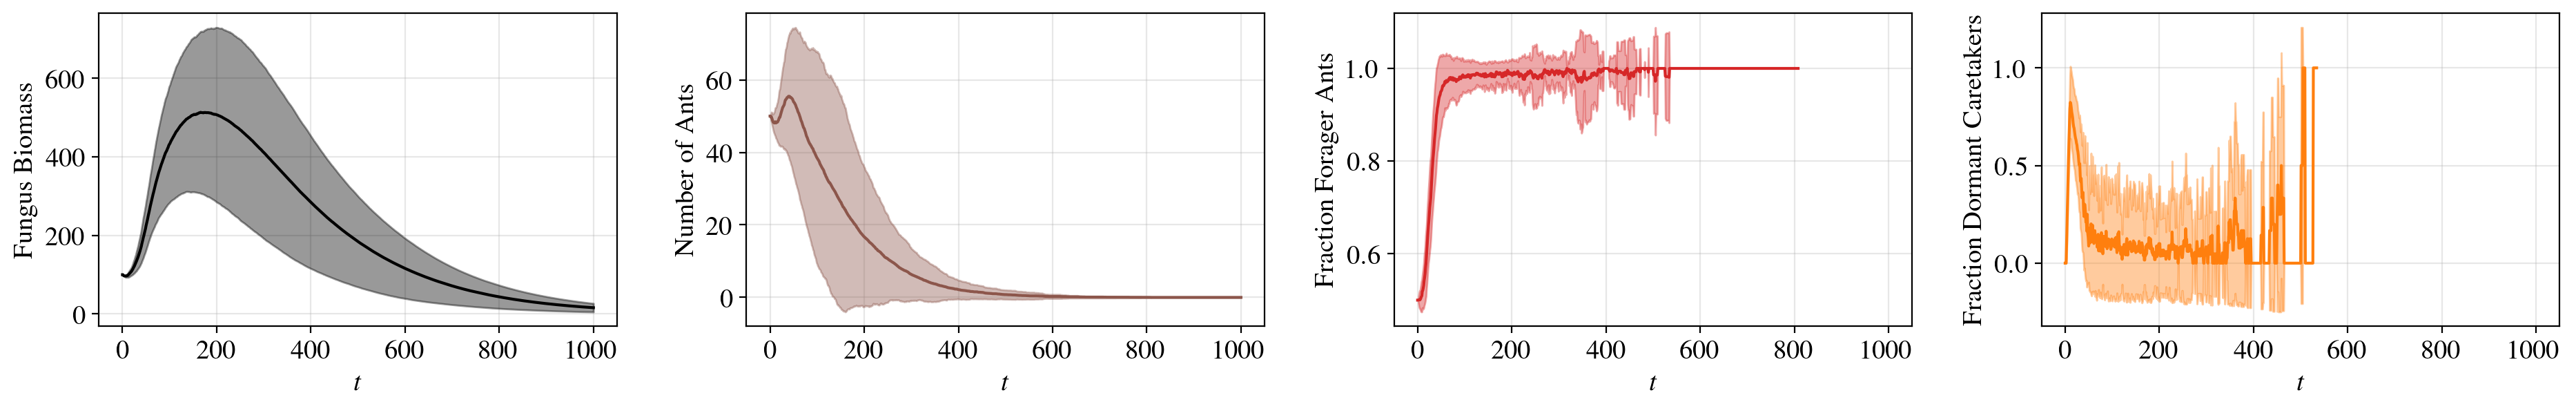

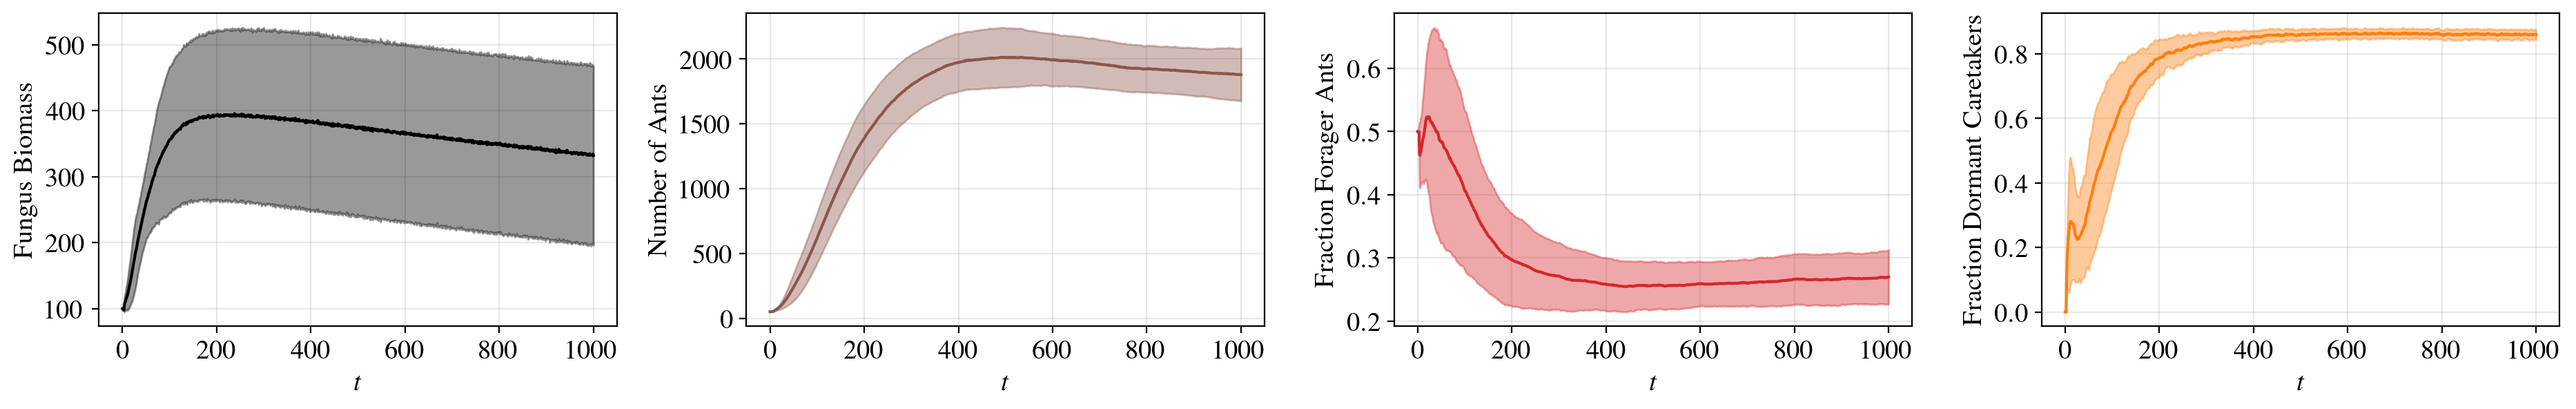

In [81]:
plot_mean_std(extinct_ex1, experiment_name = "Global look extinct.pdf", measures = cols, colors = colors, x_lim=1000,
              wspace=0.25)
plot_mean_std(survive_ex1,  experiment_name = "Global look survive.pdf", measures = cols, colors = colors, x_lim=1000,
              wspace=0.25)

Probably in appendix or not in paper: 

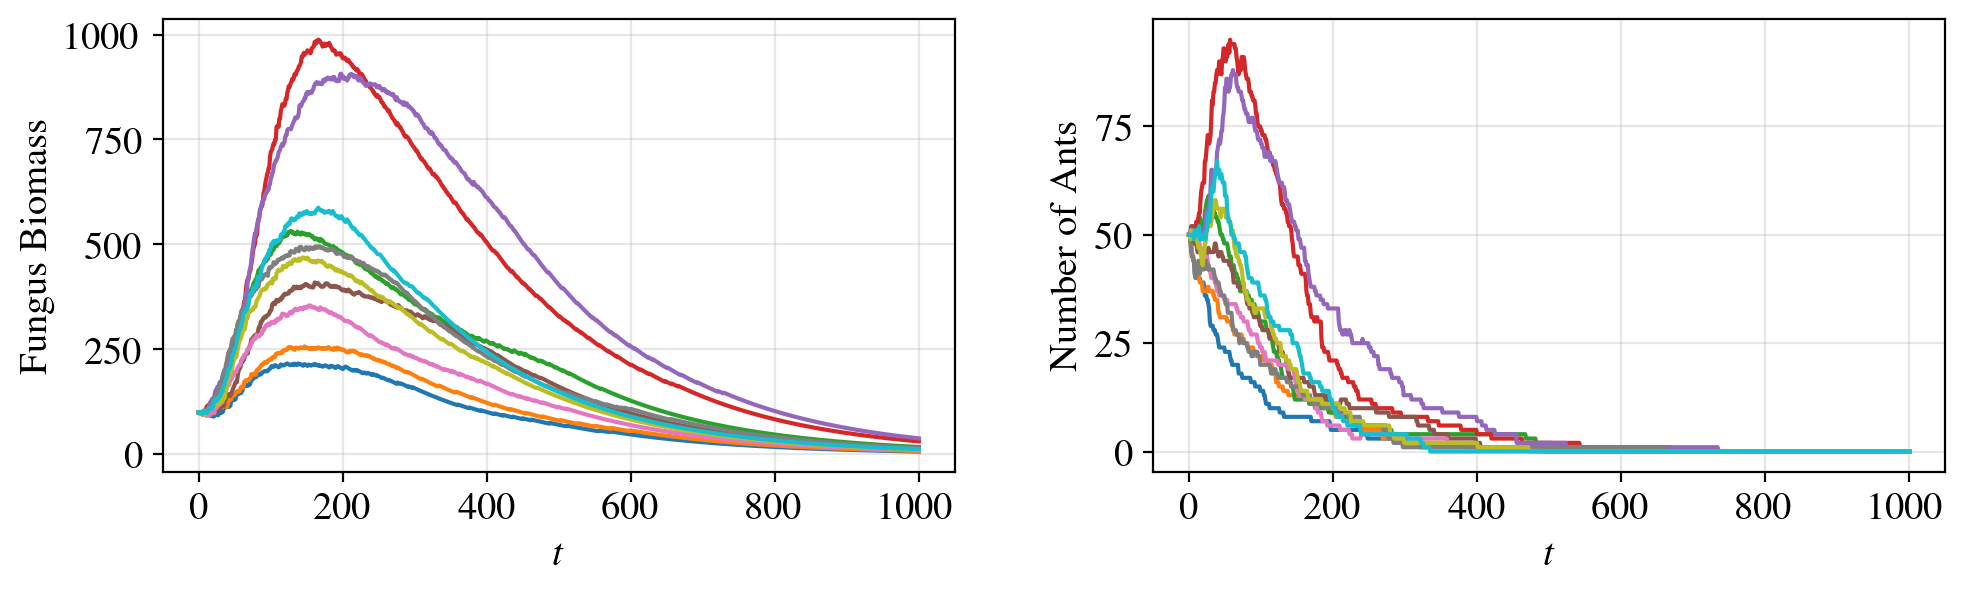

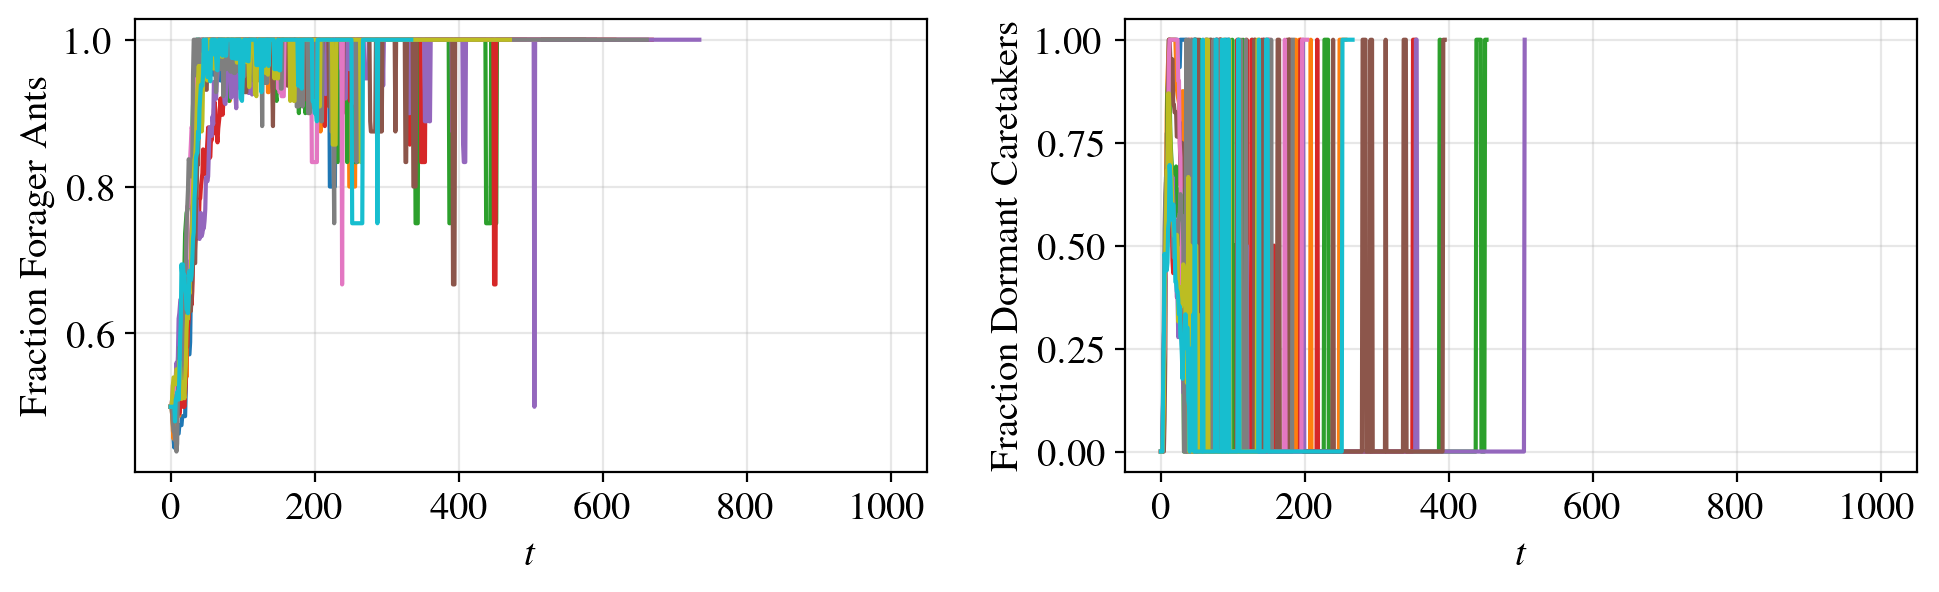

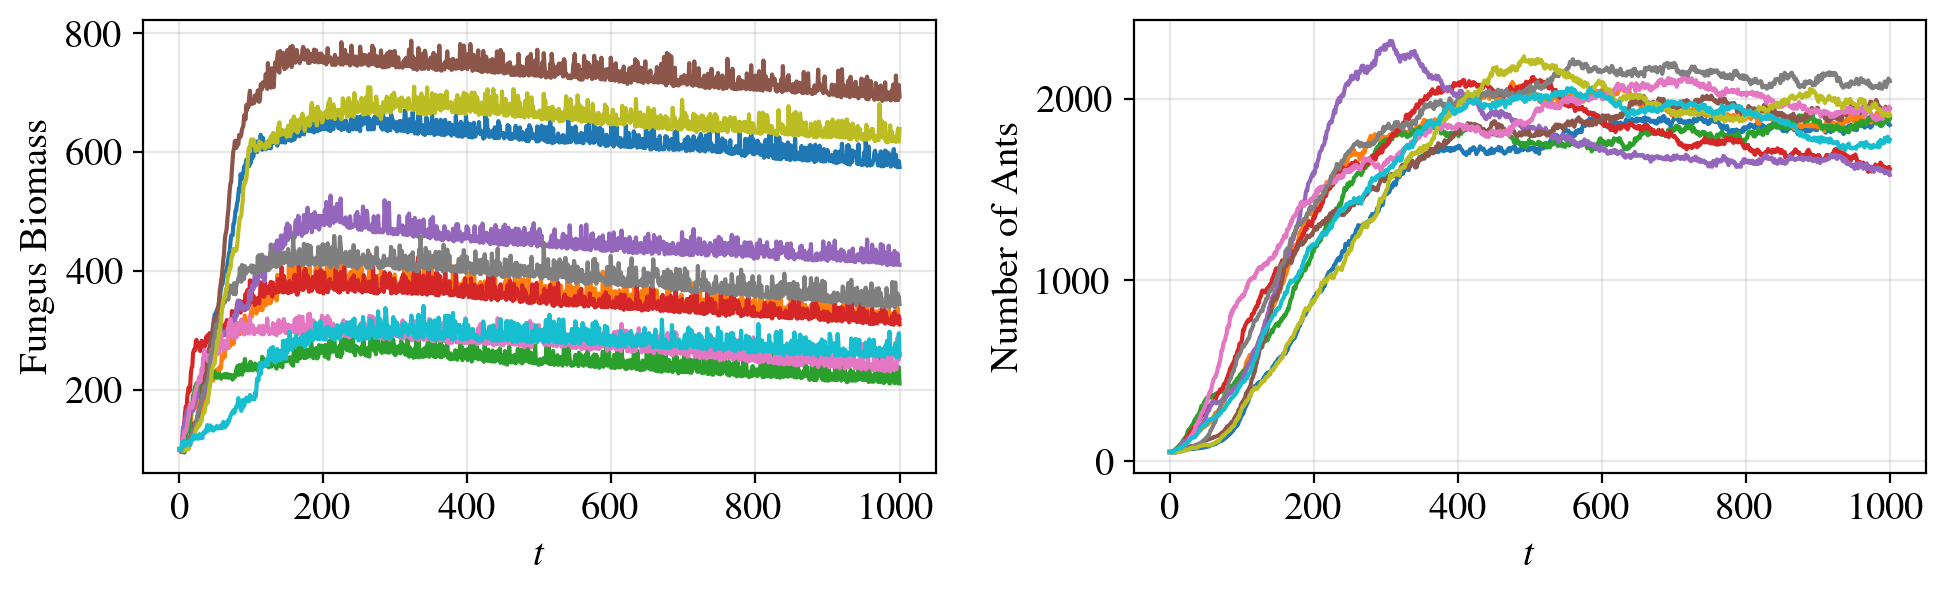

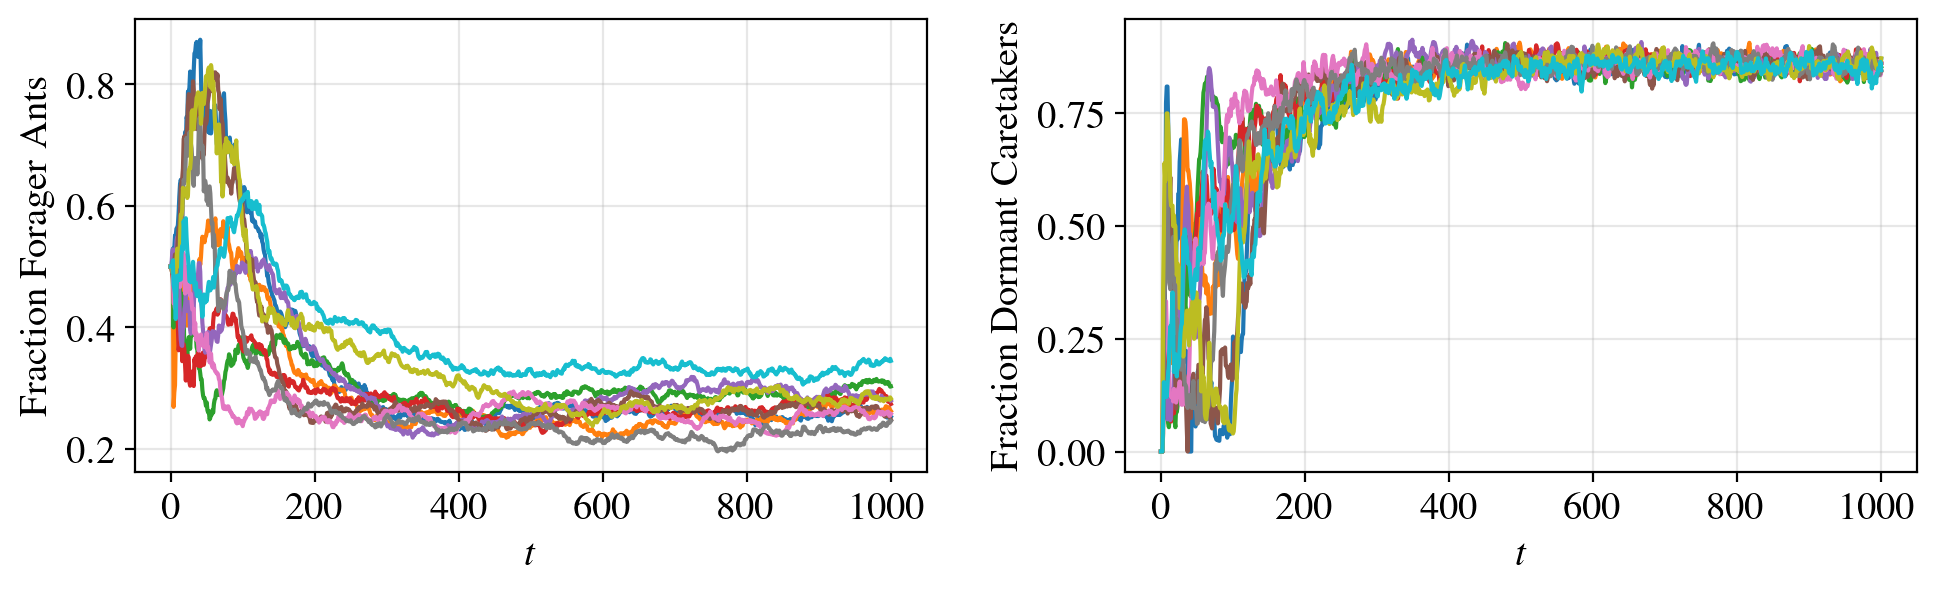

In [82]:
plot_runs(extinct_ex1[0:10],  file_name = "Global look extinct all runs02.pdf", measures = cols[0:2], colors = colors, x_lim=1000,
          wspace=0.25, figsize=TWO_COL_FIGSIZE)
plot_runs(extinct_ex1[0:10],  file_name = "Global look extinct all runs24.pdf", measures = cols[2:4], colors = colors, x_lim=1000,
          wspace=0.25, figsize=TWO_COL_FIGSIZE)
plot_runs(survive_ex1[0:10], file_name = "Global look survive all runs02.pdf", measures = cols[0:2], colors = colors, x_lim=1000,
          wspace=0.25, figsize=TWO_COL_FIGSIZE)
plot_runs(survive_ex1[0:10], file_name = "Global look survive all runs24.pdf", measures = cols[2:4], colors = colors, x_lim=1000,
          wspace=0.25, figsize=TWO_COL_FIGSIZE)

Probably in appendix or not in paper: 

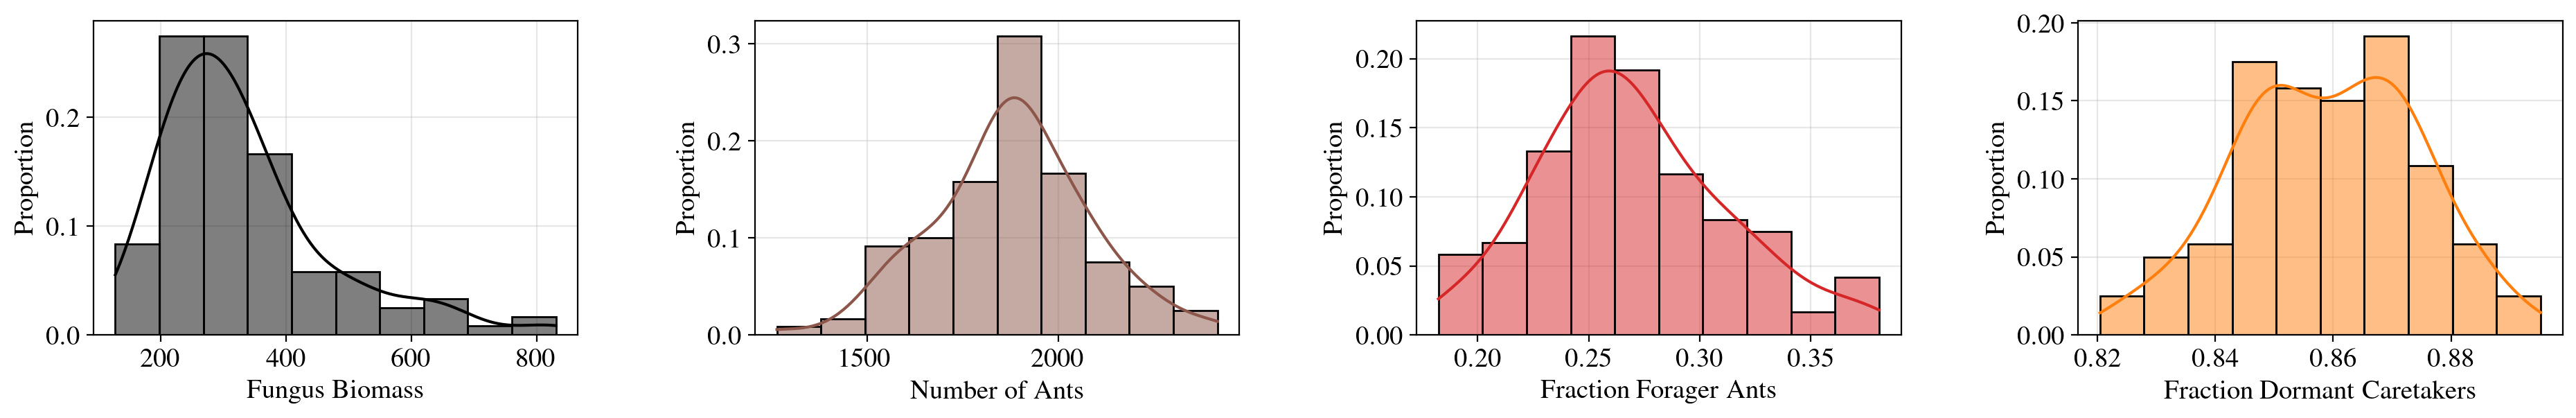

In [83]:
plot_hist(survive_ex1, file_name = "Runs_non_extinct_ex1_hist.pdf", measures = cols, colors = colors)

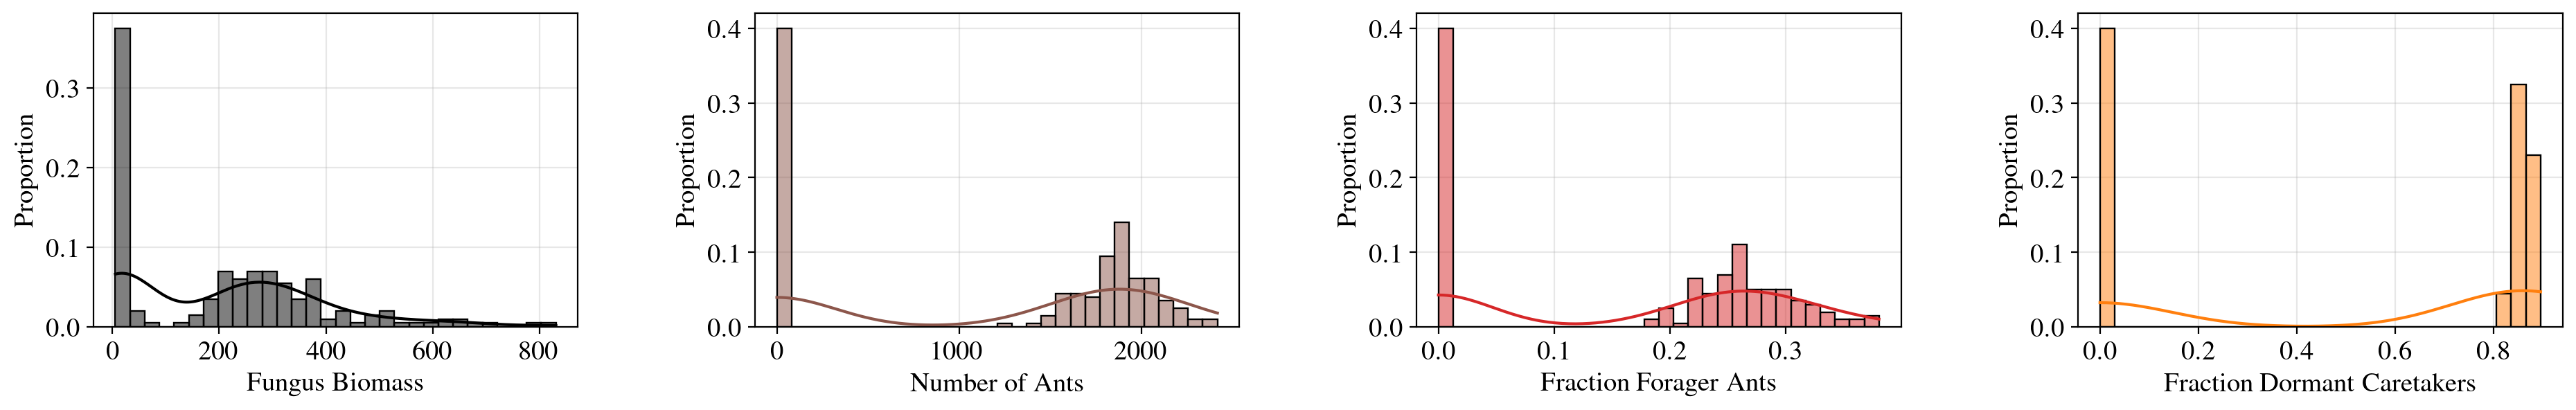

In [84]:
plot_hist(dfs_ex1_unchanged, file_name = "Runs_total_ex1_hist.pdf", measures = cols, colors = colors, bins = 30)

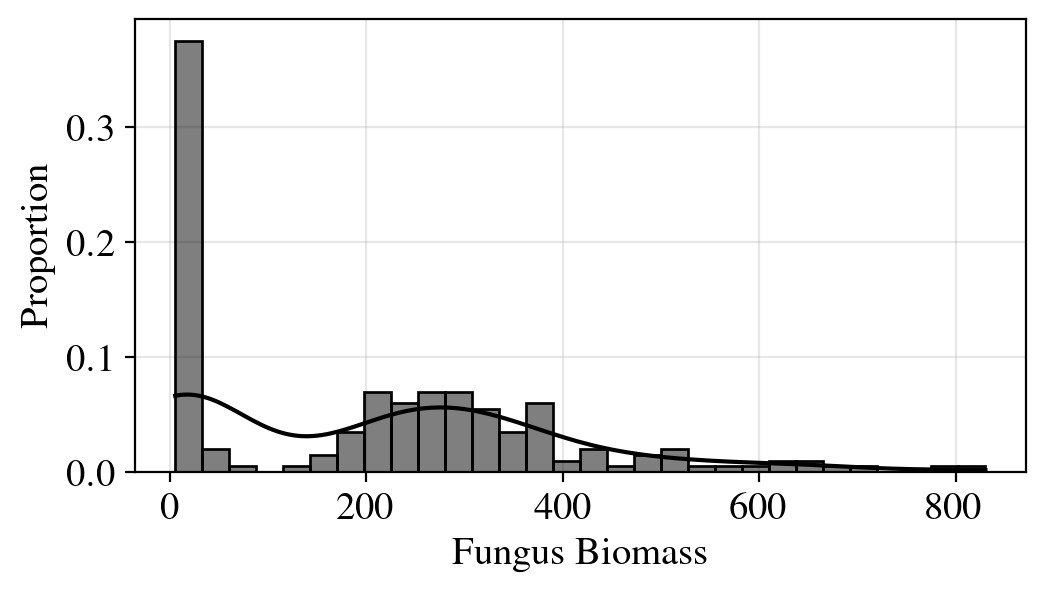

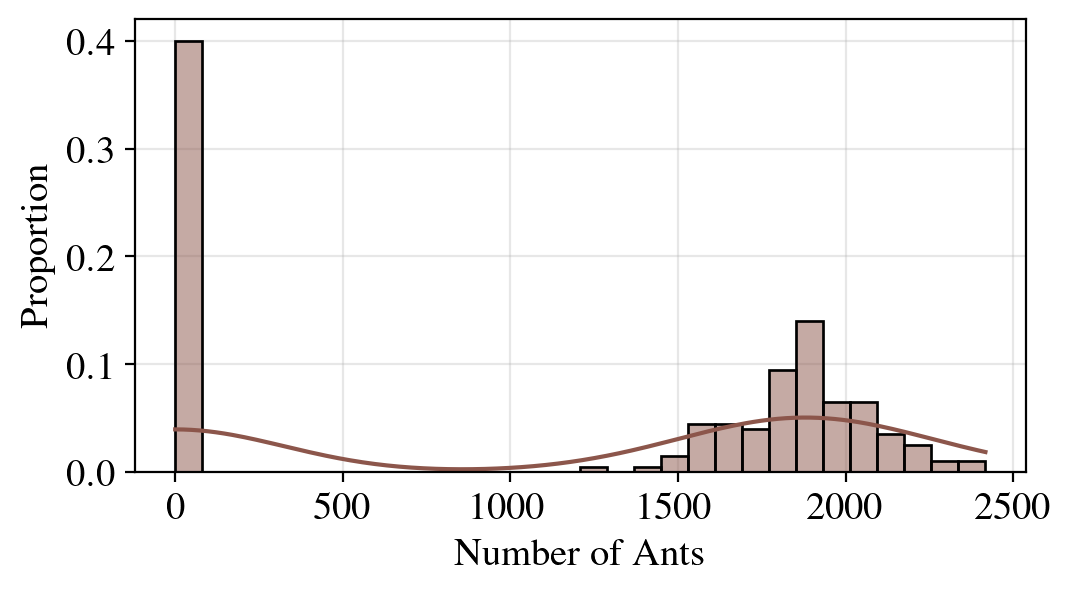

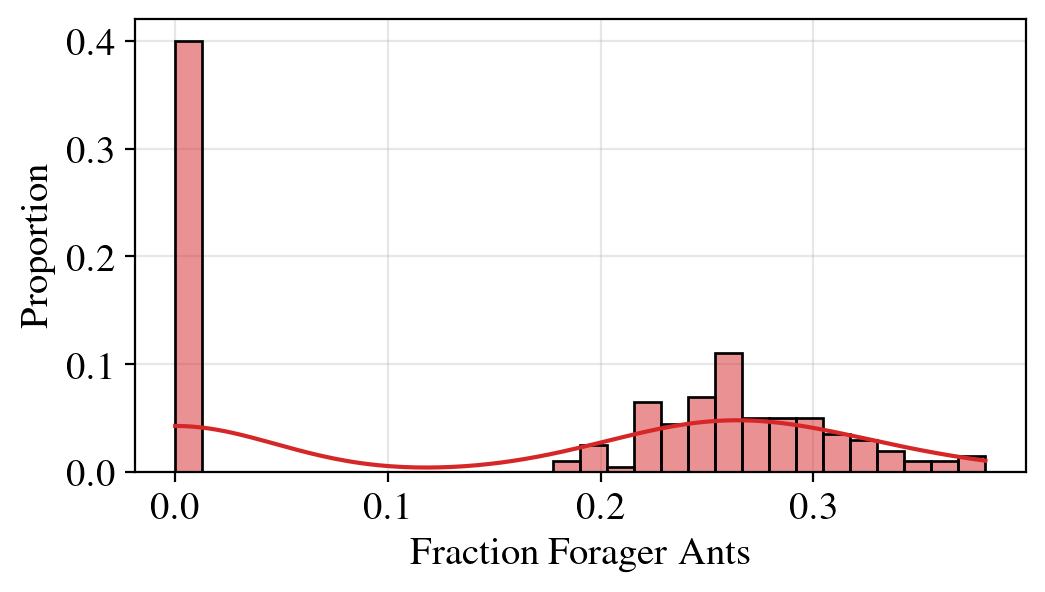

In [12]:
plot_hist(dfs_ex1_unchanged, file_name = "Hist_fungus.pdf", measures = (cols[0],), colors = (colors[0],), bins = 30)
plot_hist(dfs_ex1_unchanged, file_name = "Hist_Ants.pdf", measures = (cols[1],), colors = (colors[1],), bins = 30)
plot_hist(dfs_ex1_unchanged, file_name = "Hist_Foragers.pdf", measures = (cols[2],), colors = (colors[2],), bins = 30)

(-0.29497230552470555, 0.0010734792384292985)


<Figure size 700x400 with 0 Axes>

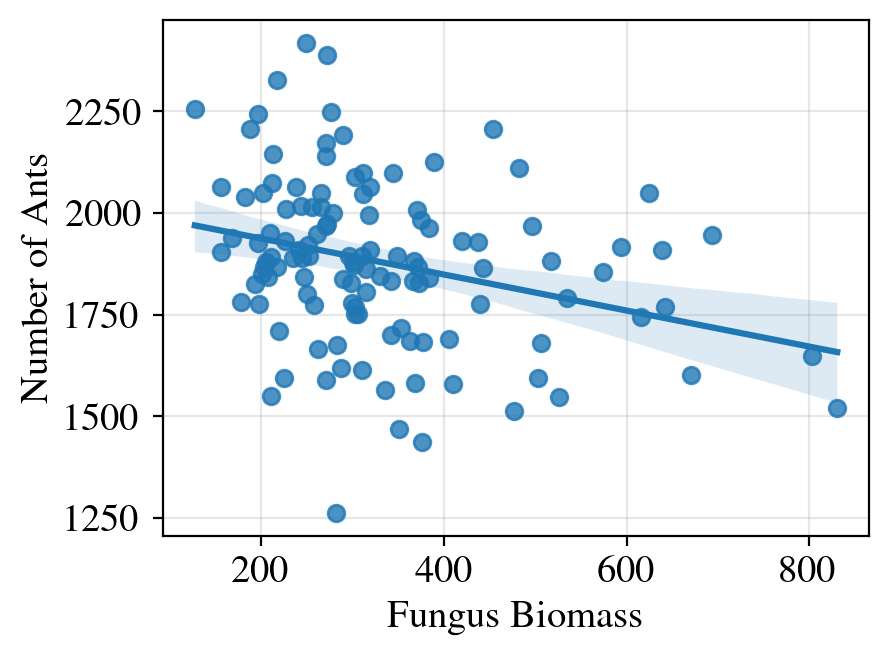

(0.22013519393755182, 0.015694907019858633)


<Figure size 700x400 with 0 Axes>

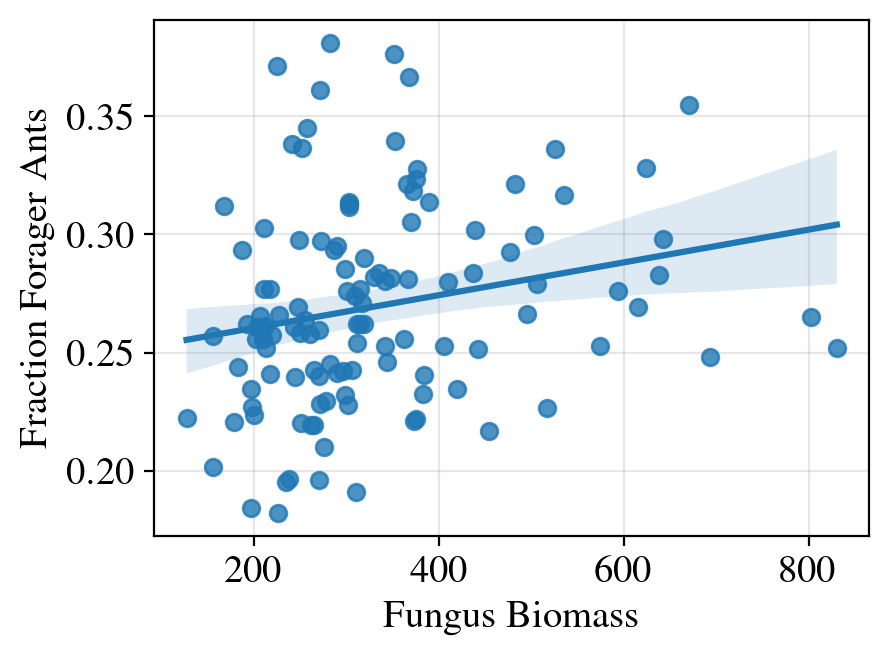

(-0.39783339051809363, 6.808166947943179e-06)


<Figure size 700x400 with 0 Axes>

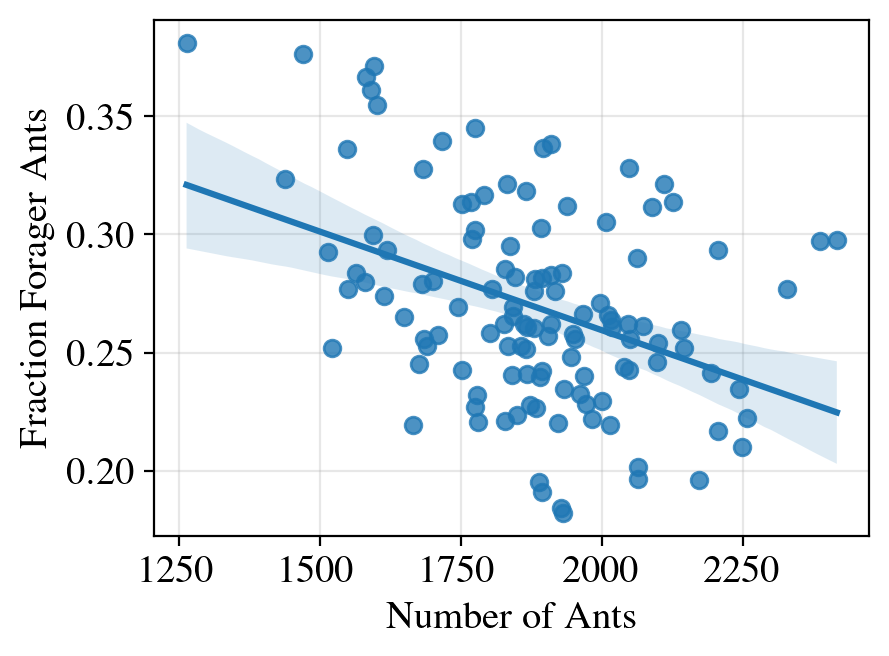

(0.042937355582824084, 0.6414683118253548)


<Figure size 700x400 with 0 Axes>

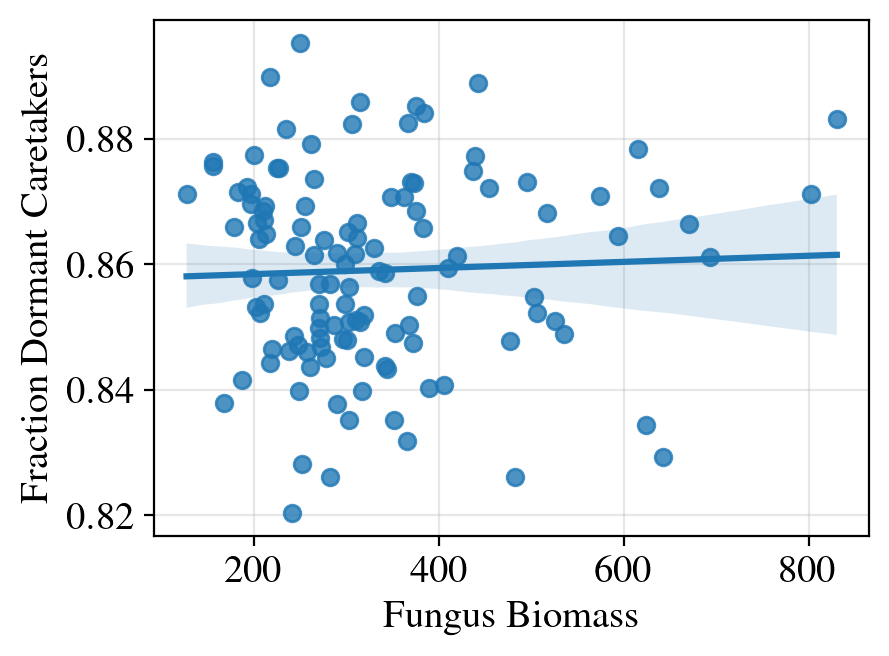

In [17]:
#cols = ("Fungus Biomass", "Number of Ants", "Fraction Forager Ants", "Fraction Dormant Caretakers")
scatterplot(survive_ex1, "Scatter_Fungus_Ants.pdf", "Fungus Biomass", "Number of Ants")
scatterplot(survive_ex1, "Scatter_Fungus_Forager.pdf", "Fungus Biomass", "Fraction Forager Ants")
scatterplot(survive_ex1, "Scatter_Ants_Forager.pdf", "Number of Ants", "Fraction Forager Ants")
scatterplot(survive_ex1, "Scatter_Fungus_Dormant.pdf", "Fungus Biomass", "Fraction Dormant Caretakers")

## Focused look

The question really here is: What happens in that crucial initial stage, where some population go extinct? A connection can be found with the amounts of ants with leaves, which is having trouble to establish those initial pheromone trails.  

In [87]:
def plot_mean_std_overlay(list_dfs_states, measure, colours, y_range_max=None, x_lim=None):
    fig = plt.figure(figsize=(5, 3.75))
    x_lim += 1
    
    i = 0
    for state in list_dfs_states: 
        concat_df = pd.concat(state)
        grouped_df = concat_df.groupby(level=0)
        means_df = grouped_df.mean()
        std_df = grouped_df.std()

        plt.plot(range(x_lim), means_df[measure][:x_lim], label=measure, color=colours[i])
    
        mean_min_std = means_df[measure] - std_df[measure]
        #mean_min_std[mean_min_std < 0] = 0

        plt.fill_between(range(x_lim),
                         mean_min_std[:x_lim], means_df[measure][:x_lim] + std_df[measure][:x_lim],
                         alpha=0.4, color=colours[i])
        plt.xlabel("$t$", fontsize=15)
        plt.ylabel(f"{measure}", fontsize=15)

        if y_range_max:
            plt.ylim(-0.05*y_range_max, y_range_max+0.05*y_range_max)

        if x_lim:
            plt.xlim(-0.05*x_lim, x_lim+0.05*x_lim)
            
        i += 1

        plt.legend(["Unsuccessful", "Successful"], loc = 1)
        plt.tight_layout()
        plt.savefig(f"figures/experiments/Focused look/{measure}.pdf", bbox_inches='tight')
    plt.show()

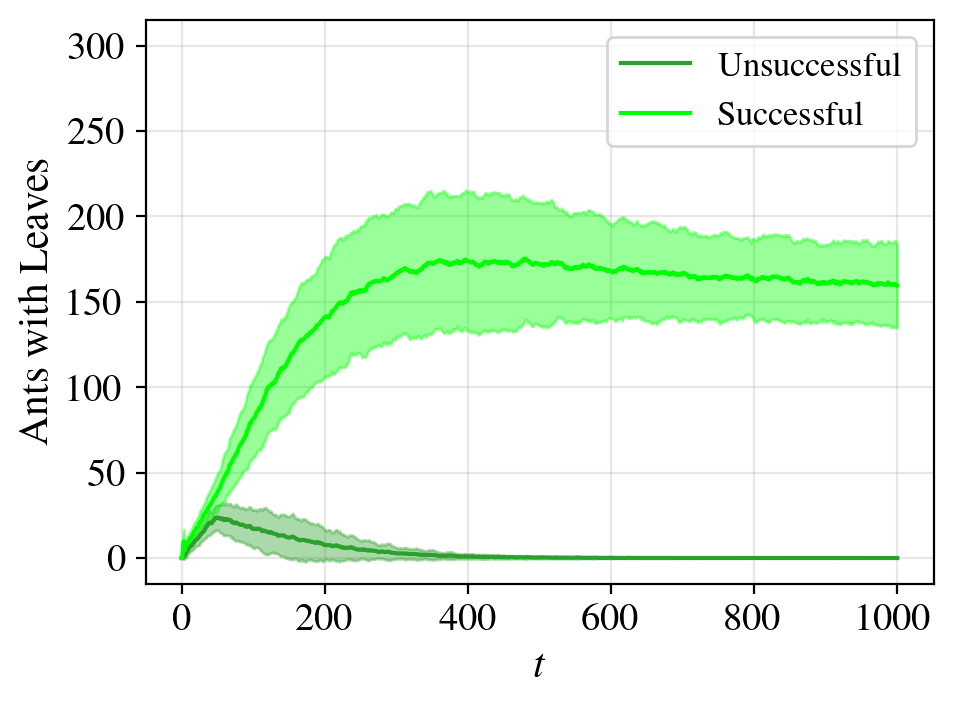

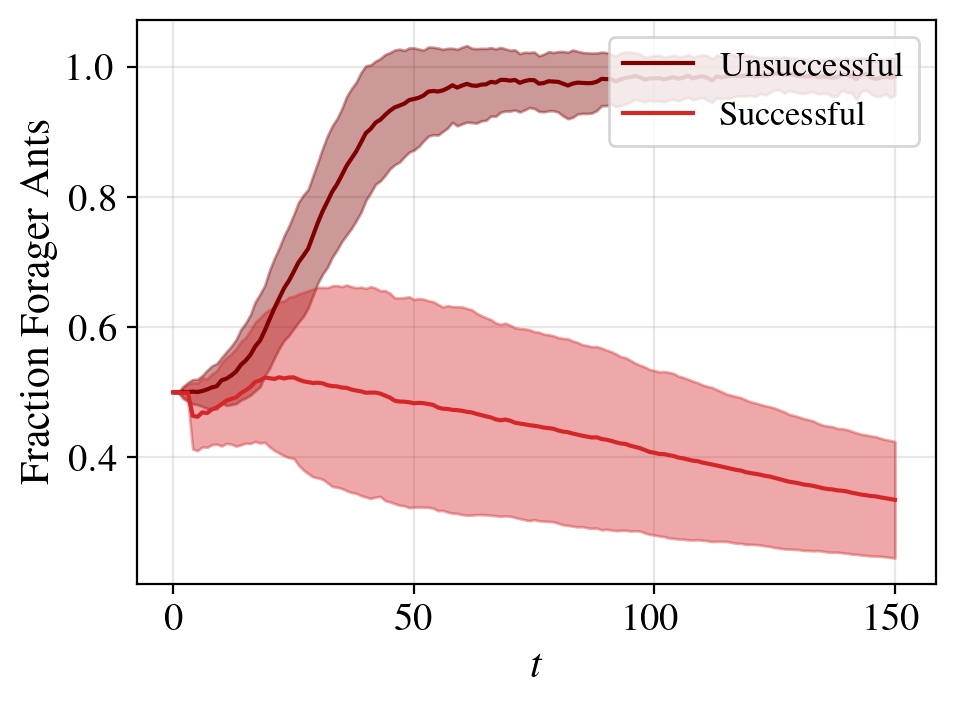

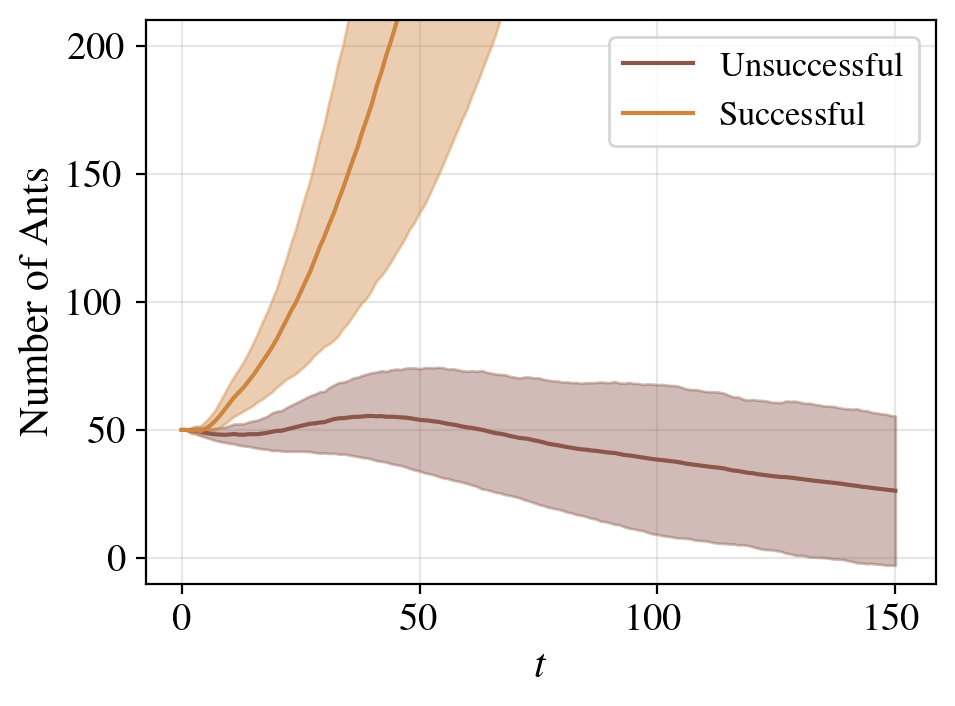

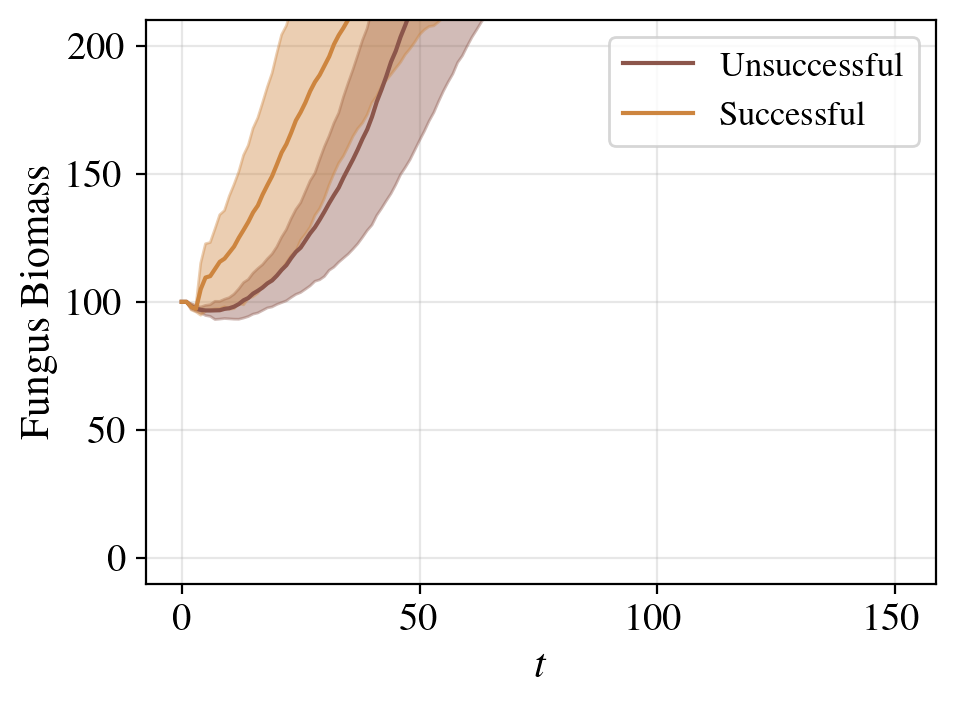

In [88]:
plot_mean_std_overlay([extinct_ex1, survive_ex1], measure = "Ants with Leaves", colours = ["tab:green", "lime"],
                     y_range_max=300, x_lim=1000)
plot_mean_std_overlay([extinct_ex1, survive_ex1], measure = "Fraction Forager Ants", colours = [ "maroon", "tab:red"],
                      x_lim=150)
plot_mean_std_overlay([extinct_ex1, survive_ex1], measure = "Number of Ants", colours = ["tab:brown", "peru"],
                      y_range_max=200, x_lim=150)
plot_mean_std_overlay([extinct_ex1, survive_ex1], measure = "Fungus Biomass", colours = ["tab:brown", "peru"],
                      y_range_max=200, x_lim=150)

# Experiment 2

In [89]:
data_30_100 = np.load("data/time_steps_data_experiment_2_30pl_100le.npz", allow_pickle=True)
dfs_30_100 = [pd.DataFrame.from_dict(d) for d in data_30_100["results"]]
t = len(dfs_30_100[0])

data_60_50 = np.load("data/time_steps_data_experiment_2_60pl_50le.npz", allow_pickle=True)
dfs_60_50 = [pd.DataFrame.from_dict(d) for d in data_60_50["results"]]

data_120_25 = np.load("data/time_steps_data_experiment_2_120pl_25le.npz", allow_pickle=True)
dfs_120_25 = [pd.DataFrame.from_dict(d) for d in data_120_25["results"]]

In [90]:
extinct_30_100 = []
survive_30_100 = []
n_extinctions = 0
for i, df in enumerate(dfs_30_100):
    #rename collumns
    df = df.rename(columns={"Ant Biomass": "Number of Ants", "Fraction forager ants": "Fraction Forager Ants",
                        "Dormant caretakers fraction":"Fraction Dormant Caretakers"})
    dfs_30_100[i] = df
    
    if df["Number of Ants"].iloc[-1] < 5:
        n_extinctions += 1
        extinct_30_100.append(df)
    else: 
        survive_30_100.append(df)
print(f"{n_extinctions} out of {len(dfs_30_100)} runs went extinct")

137 out of 200 runs went extinct


In [91]:
extinct_60_50 = []
survive_60_50 = []
n_extinctions = 0

for i, df in enumerate(dfs_60_50):
    #rename collumns
    df = df.rename(columns={"Ant Biomass": "Number of Ants", "Fraction forager ants": "Fraction Forager Ants",
                        "Dormant caretakers fraction":"Fraction Dormant Caretakers"})
    dfs_60_50[i] = df

    if df["Number of Ants"].iloc[-1] < 5:
        n_extinctions += 1
        extinct_60_50.append(df)
    else: 
        survive_60_50.append(df)
print(f"{n_extinctions} out of {len(dfs_60_50)} runs went extinct")

84 out of 200 runs went extinct


In [92]:
extinct_120_25 = []
survive_120_25 = []
n_extinctions = 0

for i, df in enumerate(dfs_120_25):
    #rename collumns
    df = df.rename(columns={"Ant Biomass": "Number of Ants", "Fraction forager ants": "Fraction Forager Ants",
                        "Dormant caretakers fraction":"Fraction Dormant Caretakers"})
    dfs_120_25[i] = df
    
    if df["Number of Ants"].iloc[-1] < 5:
        n_extinctions += 1
        extinct_120_25.append(df)
    else: 
        survive_120_25.append(df)
print(f"{n_extinctions} out of {len(dfs_120_25)} runs went extinct")

35 out of 200 runs went extinct


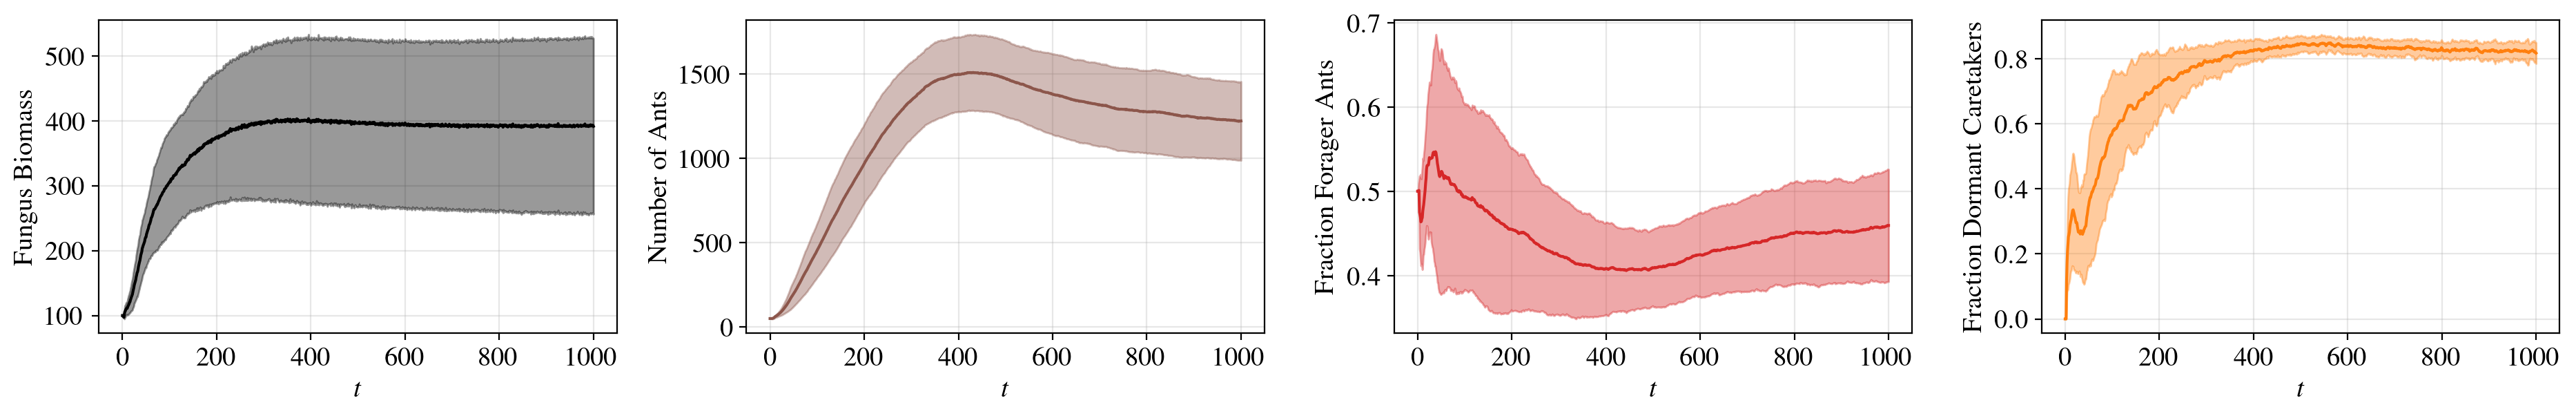

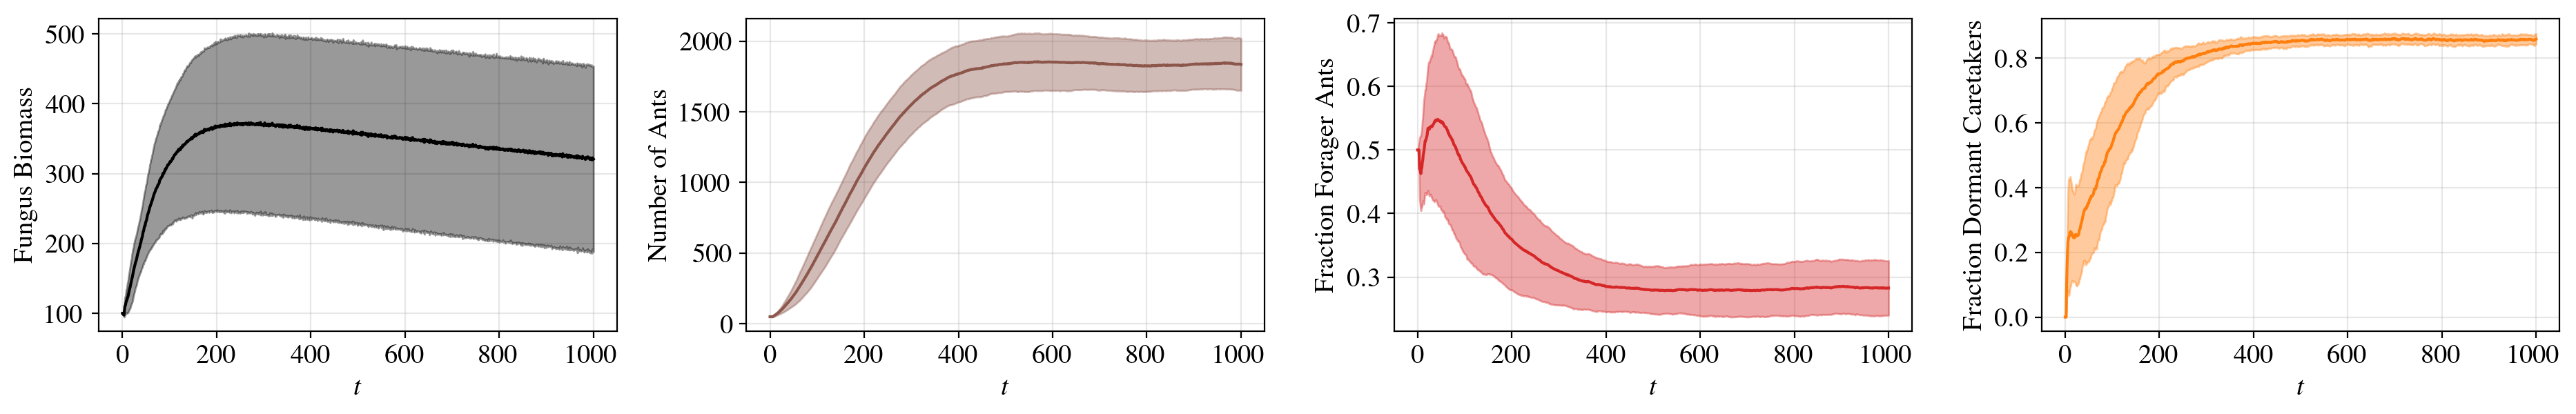

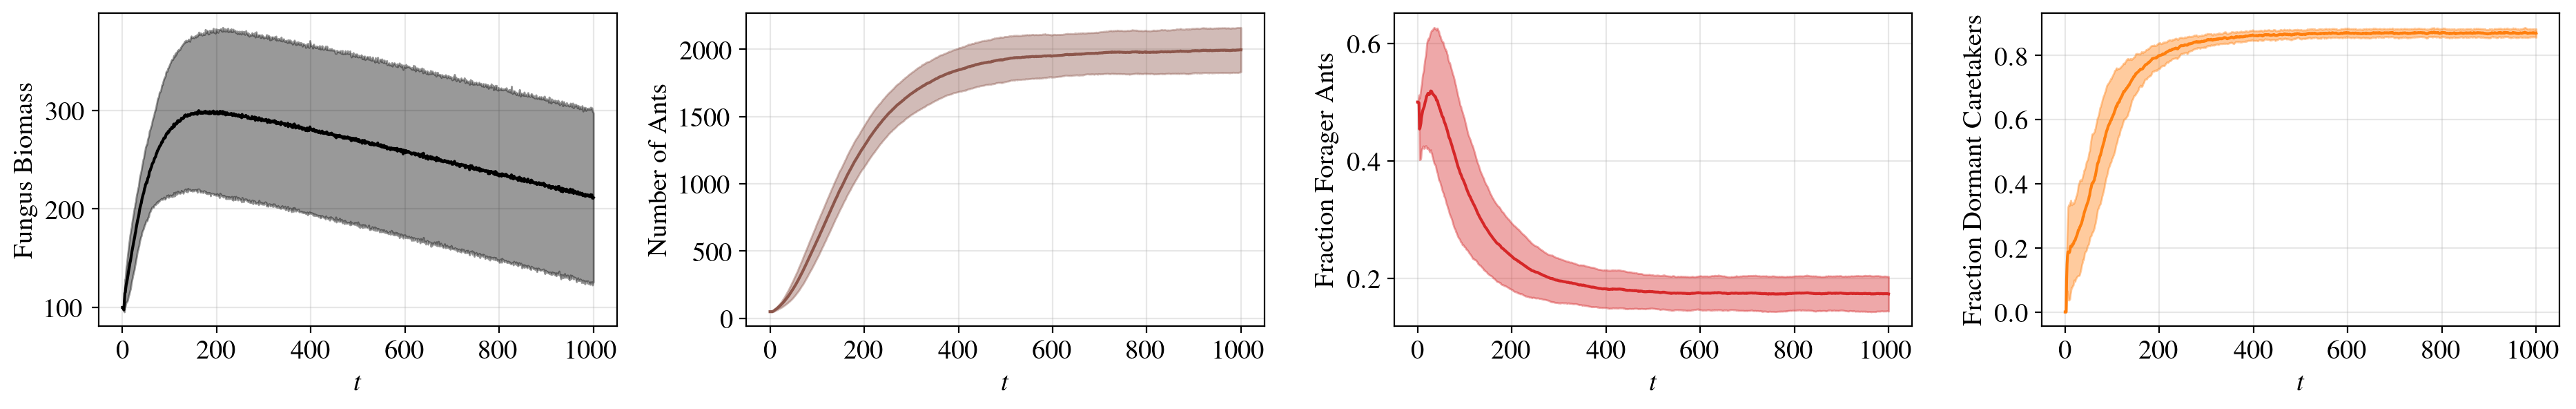

In [93]:
cols2 = ("Fungus Biomass", "Number of Ants", "Fraction Forager Ants", "Fraction Dormant Caretakers")
colors2 = ("black", "tab:brown", "tab:red", "tab:orange")
plot_mean_std(survive_30_100, experiment_name = "Stats_non_extinct_30_100_ex2.pdf", measures = cols2, colors = colors2,
              wspace=0.25)
plot_mean_std(survive_60_50, experiment_name = "Stats_non_extinct_60_50_ex2.pdf", measures = cols2, colors = colors2,
              wspace=0.25)
plot_mean_std(survive_120_25, experiment_name = "Stats_non_extinct_120_25_ex2.pdf", measures = cols2, colors = colors2,
              wspace=0.25)

#plot_runs(non_extinct_dfs_30_100, title = "30 plants, 100 leaves", file_name = "Stats_extinct_30_100.pdf")
#plot_runs(non_extinct_dfs_60_50, title = "60 plants, 50 leaves")
#plot_runs(non_extinct_dfs_120_25, title = "120 plants, 25 leaves")

## Statistical test

In [94]:
def F_test(Samples_A, Samples_B):
    """ Calculates the F-test based on the data from two datasets.
        Returns:
            F-statistics (int)
            p=value (int)
    """
    A_var,  A_len = np.var(Samples_A, ddof = 1), len(Samples_A)
    B_var, B_len = np.var(Samples_B, ddof = 1), len(Samples_B)
    F = max(A_var/B_var, B_var/A_var)
    if A_var > B_var:
        n1 = A_len
        n2 = B_len
    else: 
        n2 = A_len
        n1 = B_len
    p_value = 1 - stats.f.cdf(F, (n1 - 1), (n2 - 1))
    return F, p_value

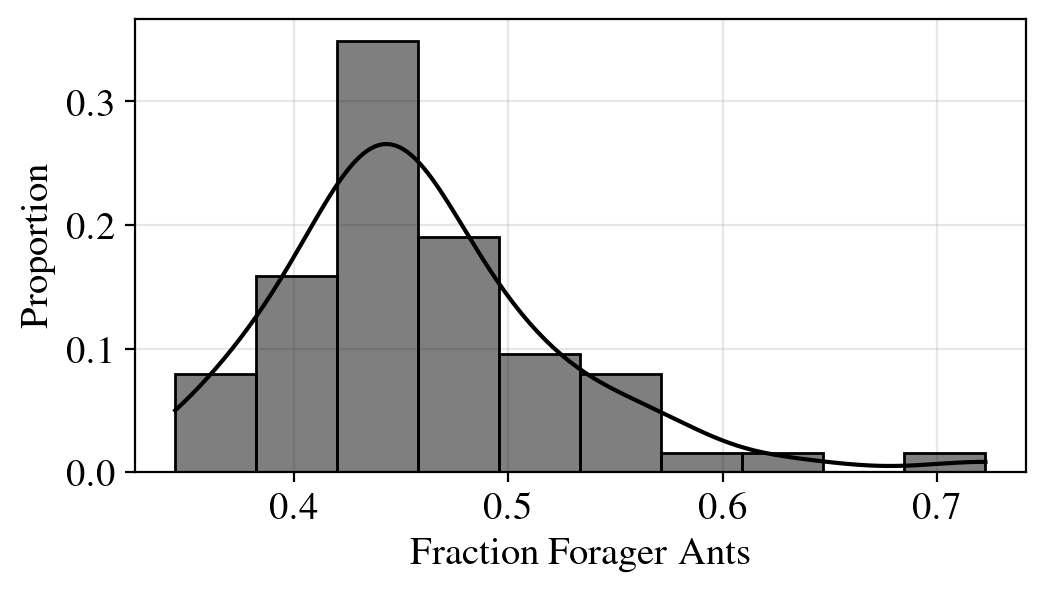

In [95]:
plot_hist(survive_30_100, file_name = "", measures = ("Fraction Forager Ants",), colors = colors)

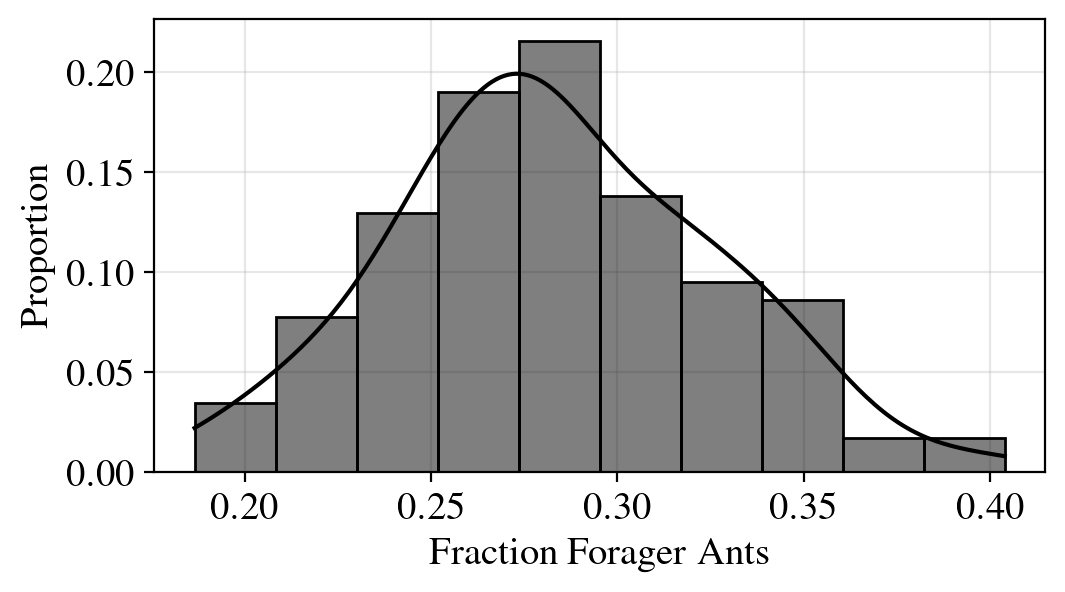

In [96]:
plot_hist(survive_60_50, file_name = "", measures = ("Fraction Forager Ants",), colors = colors)

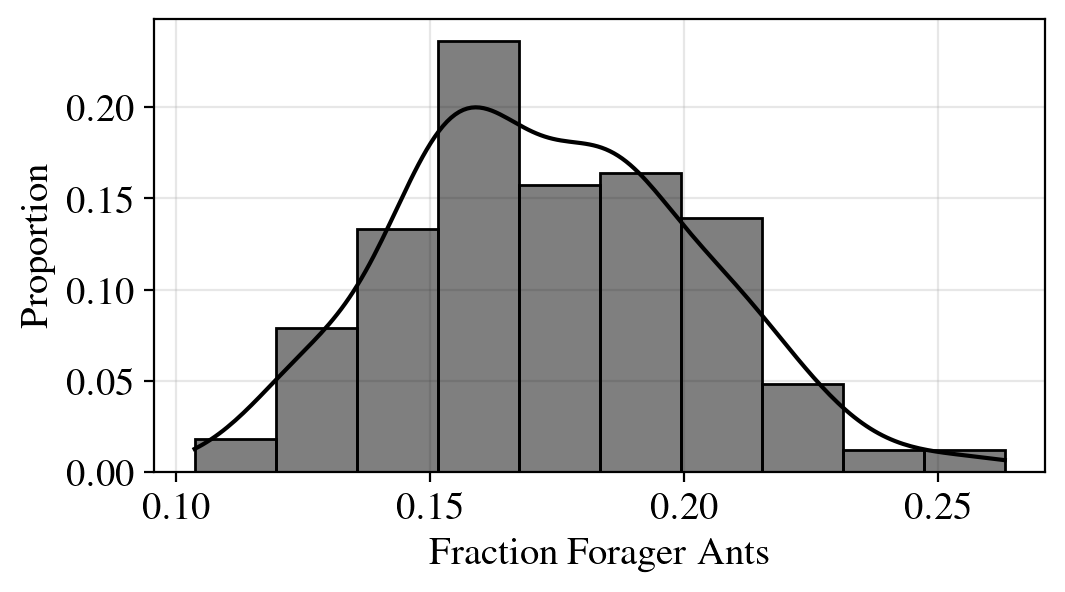

In [97]:
plot_hist(survive_120_25, file_name = "", measures = ("Fraction Forager Ants",), colors = colors)

In [98]:
survive_30_100_final = []
survive_60_50_final = []
survive_120_25_final = []

for df in survive_30_100:
    survive_30_100_final.append(df["Fraction Forager Ants"].iloc[-1])
    
for df in survive_60_50:
    survive_60_50_final.append(df["Fraction Forager Ants"].iloc[-1])
    
for df in survive_120_25:
    survive_120_25_final.append(df["Fraction Forager Ants"].iloc[-1])

In [99]:
len(survive_30_100_final), len(survive_60_50_final), len(survive_120_25)

(63, 116, 165)

In [100]:
survive_30_100_60_50_stats = F_test(survive_30_100_final, survive_60_50_final)
survive_30_100_120_25_stats = F_test(survive_30_100_final, survive_120_25_final)
survive_60_50_120_25_stats = F_test(survive_60_50_final, survive_120_25_final)

survive_30_100_60_50_stats, survive_30_100_120_25_stats, survive_60_50_120_25_stats

((2.3977053728743964, 2.5655914377642475e-05),
 (5.096424754895492, 1.1102230246251565e-16),
 (2.125542534354769, 4.675678665910787e-06))

In [101]:
reject_a, pvals_corrected_a, _, _ = multitest.multipletests(
    pvals = [survive_30_100_60_50_stats[1], survive_30_100_120_25_stats[1], survive_60_50_120_25_stats[1]],
    alpha = 0.05, method = "bonferroni")
print(pvals_corrected_a)
print(reject_a)

[7.69677431e-05 3.33066907e-16 1.40270360e-05]
[ True  True  True]


In [102]:
statistic_1W, p_value_1W = stats.ttest_ind(survive_30_100_final, survive_60_50_final, equal_var = False)
statistic_2W, p_value_2W = stats.ttest_ind(survive_30_100_final, survive_120_25_final, equal_var = False)
statistic_3W, p_value_3W = stats.ttest_ind(survive_60_50_final, survive_120_25_final, equal_var = False)

In [103]:
p_value_1W, p_value_2W, p_value_3W

(2.241651777057655e-33, 6.555755759437917e-45, 8.502202728365635e-59)

In [104]:
reject_a, pvals_corrected_a, _, _ = multitest.multipletests(
    pvals = [p_value_1W, p_value_2W, p_value_3W],
    alpha = 0.05, method = "bonferroni")
print(pvals_corrected_a)
print(reject_a)

[6.72495533e-33 1.96672673e-44 2.55066082e-58]
[ True  True  True]
